# Homework 5
**Author:** David James

**Date:** 2019 February 19

### Problem 1: Fit Steinhart and Hart Equation
- Equation: 
$ \frac{1}{T} = A + B (\ln(R)) + C (\ln(R))^2 + D (\ln(R))^3 $

In [2]:
import matplotlib.pyplot as plt
import datetime as dt
import scipy.io as sio
import numpy as np
import serial
from time import time
from lmfit import minimize, Parameters
now = dt.datetime.now().strftime("%Y-%m-%d")

In [2]:
prob1Data = sio.loadmat('Therm3950_Data.mat')
T = np.concatenate(prob1Data['Temp_degK'])
R = np.concatenate(prob1Data['Resist_Ohm'])

lv = ((T >= 273.15) & (T < 323.15))
tlv = T[lv]
rlv = R[lv]

In [3]:
params = Parameters()
params.add('a', value=1e-3)
params.add('b',value=1e-4)
params.add('c',value=1e-7)
params.add('d',value=1e-8)

def steinhart(a,b,c,d,res):
    return (a + b*np.log(res)+c*np.log(res)**2+d*np.log(res)**3)**(-1)

def residual(params,temp,res):
    a = params['a']
    b = params['b']
    c = params['c']
    d = params['d']
    return steinhart(a,b,c,d,res) - temp

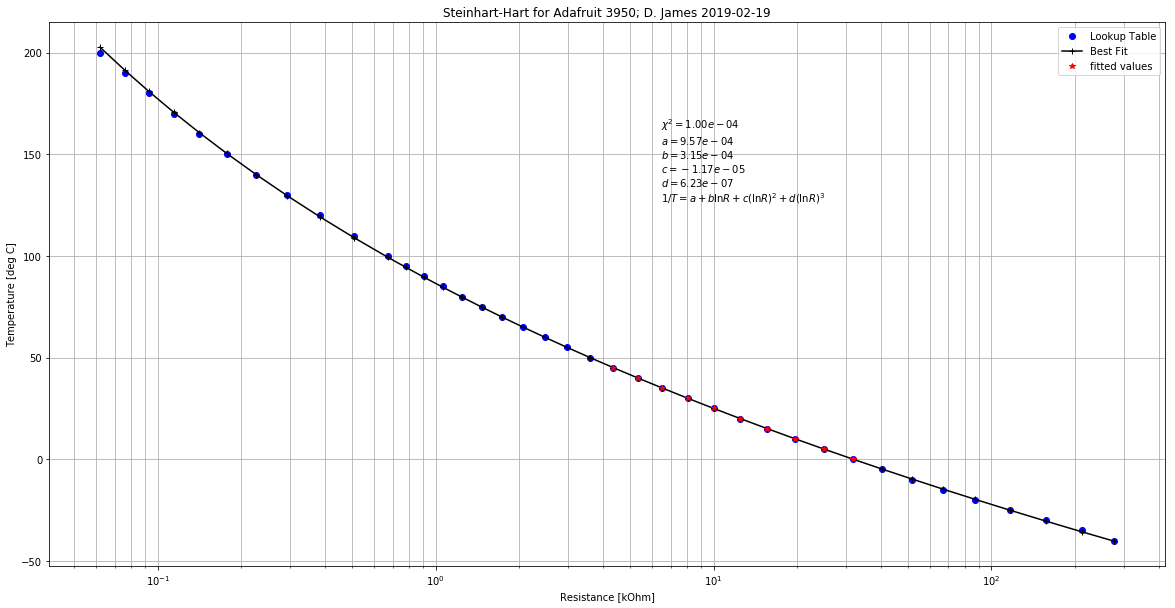

In [4]:
out = minimize(residual,params,args=(tlv,rlv))
a = out.params['a'].value
b = out.params['b'].value
c = out.params['c'].value
d = out.params['d'].value

fig = plt.figure(figsize=(20,10))
plt.semilogx(R/1000,T-273.15,'bo',label='Lookup Table')
plt.semilogx(R/1000,(steinhart(a,b,c,d,R)-273.15),'k-+',label='Best Fit')
plt.semilogx(rlv/1000,tlv-273.15,'r*',label='fitted values')

textstr = '\n'.join((
    r'$\chi^2=%3.2e$' % (out.chisqr, ),
    r'$a=%3.2e$' % (a, ),
    r'$b=%3.2e$' % (b, ),
    r'$c=%3.2e$' % (c, ),
    r'$d=%3.2e$' % (d, ),
    r'$1/T=a+b\ln R +c(\ln R)^2 +d(\ln R)^3$'))
fig.text(0.55, 0.75,textstr,verticalalignment='top')

plt.xlabel('Resistance [kOhm]')
plt.ylabel('Temperature [deg C]')
plt.title('Steinhart-Hart for Adafruit 3950; D. James '+now)
plt.legend()
plt.grid(which='both')
fig.savefig('problem1.png')

### Problem 2

- create function that converts a given thermistor resistance into a temperature in degrees Celsius

In [5]:
def temp3950(res):
    return steinhart(a,b,c,d,res) - 273.15

### Problem 3

- create a function that converts voltage measured into a resistance
- [arduino library](https://hub.packtpub.com/prototyping-arduino-projects-using-python/)

In [6]:
def rst3950(volt):
    voltTotal = 5
    resFixed = 10
    return volt/(voltTotal - volt)*resFixed

### Problem 4

- Write a DAQ script

In [7]:
port = '/dev/ttyUSB0'
hal9001 = serial.Serial(port,9600)

In [1]:
start_time = time()
timepoints = []
voltVals = []
yrange = [-0.1,5.1]
view_time = 1 # seconds of data to view at once
duration = 60 # total seconds to collect data

hal9001.flushInput()
run = True

while run:
    hal9001.reset_input_buffer()
    data = hal9001.readline().split(b' ')
    data = data[0].decode("utf-8")[0:-2]
    print(data)
    
    try:
        voltVals.append(data)
        timepoints.append(time()-start_time)
        current_time = timepoints[-1]
        
        if timepoints[-1] > duration: run=False
    except: pass

sio.savemat('data.mat',{'volt':voltVals,'time':timepoints})

NameError: name 'time' is not defined

In [12]:
prob4Data = sio.loadmat('data.mat')
volt = prob4Data['voltt']
time = prob4Data['time'][0]

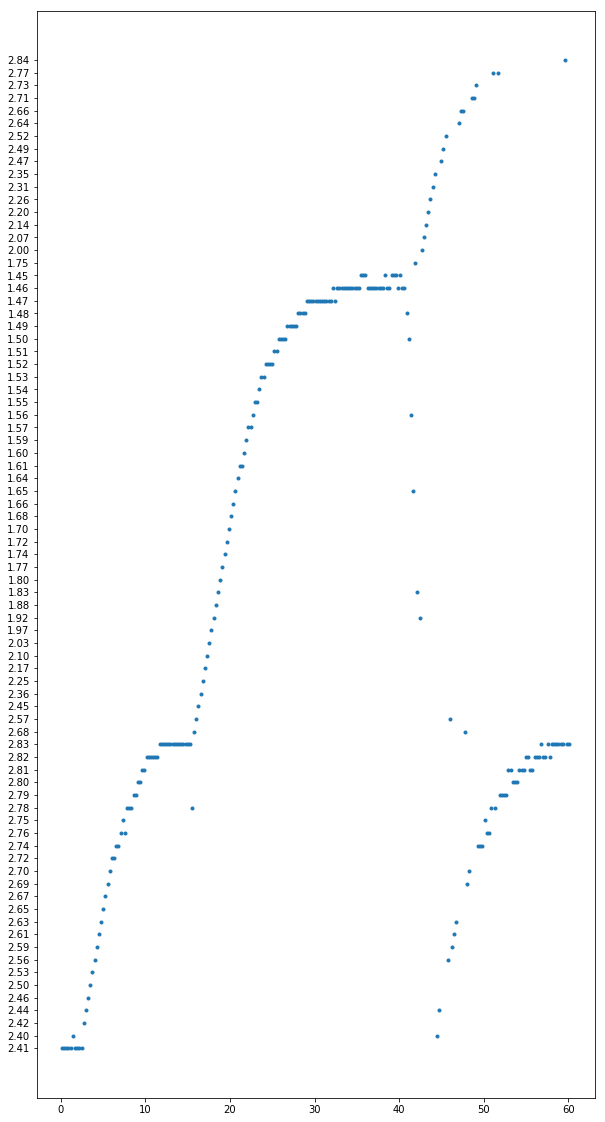

In [16]:
fig1 = plt.figure(figsize=(10,20))
plt.plot(time,volt,'.')